In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from pandas.api.types import is_numeric_dtype
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SequentialFeatureSelector
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset
# For creating a model
from torch import nn
from torch import optim
# For training
from pipetorch.train import *
from imblearn.over_sampling import SMOTE
import optuna
from optuna import create_study
from optuna.visualization.matplotlib import plot_slice, plot_contour
from sklearn.metrics import f1_score


In [44]:
# Load the data
train = pd.read_csv('midpoints.csv')

In [46]:
train.info

<bound method DataFrame.info of       0   10   20   30   40   50   60   70   80   90  ...  120  130  140  150  \
0   146  323  320  317  315  313  311  310  308  307  ...  303  302  306  312   
1   320  323  321  320  319  334  332  326  322  326  ...  316  312  319  320   
2   180  178  329  330  329  327  326  326  324  329  ...  338  365  348  337   
3   156  319  323  325  327  328  328  329  329  328  ...  334  342  348  343   
4   447  287  289  290  291  292  293  284  293  297  ...  320  320  320  320   
5   386  393  386  484  345  552    0  320  320  320  ...  320  320  320  320   
6   397  397  370  498  392  532  320  320  320  320  ...  320  320  320  320   
7   403  375  366  401  320  320  320  320  320  320  ...  320  320  320  320   
8   366  366  367  368  398    0  320  320  320  320  ...  320  320  320  320   
9   356  355  357  358  390  525  320  320  320  320  ...  320  320  320  320   
10  262  159  201  203  162  164  163  320  307  301  ...  320  320  320  320

In [48]:
train = train.dropna()

In [50]:
print(train.isna().sum())

0            0
10           0
20           0
30           0
40           0
50           0
60           0
70           0
80           0
90           0
100          0
110          0
120          0
130          0
140          0
150          0
160          0
170          0
180          0
190          0
200          0
Direction    0
dtype: int64


In [52]:
train.head

<bound method NDFrame.head of       0   10   20   30   40   50   60   70   80   90  ...  120  130  140  150  \
0   146  323  320  317  315  313  311  310  308  307  ...  303  302  306  312   
1   320  323  321  320  319  334  332  326  322  326  ...  316  312  319  320   
2   180  178  329  330  329  327  326  326  324  329  ...  338  365  348  337   
3   156  319  323  325  327  328  328  329  329  328  ...  334  342  348  343   
4   447  287  289  290  291  292  293  284  293  297  ...  320  320  320  320   
5   386  393  386  484  345  552    0  320  320  320  ...  320  320  320  320   
6   397  397  370  498  392  532  320  320  320  320  ...  320  320  320  320   
7   403  375  366  401  320  320  320  320  320  320  ...  320  320  320  320   
8   366  366  367  368  398    0  320  320  320  320  ...  320  320  320  320   
9   356  355  357  358  390  525  320  320  320  320  ...  320  320  320  320   
10  262  159  201  203  162  164  163  320  307  301  ...  320  320  320  320  

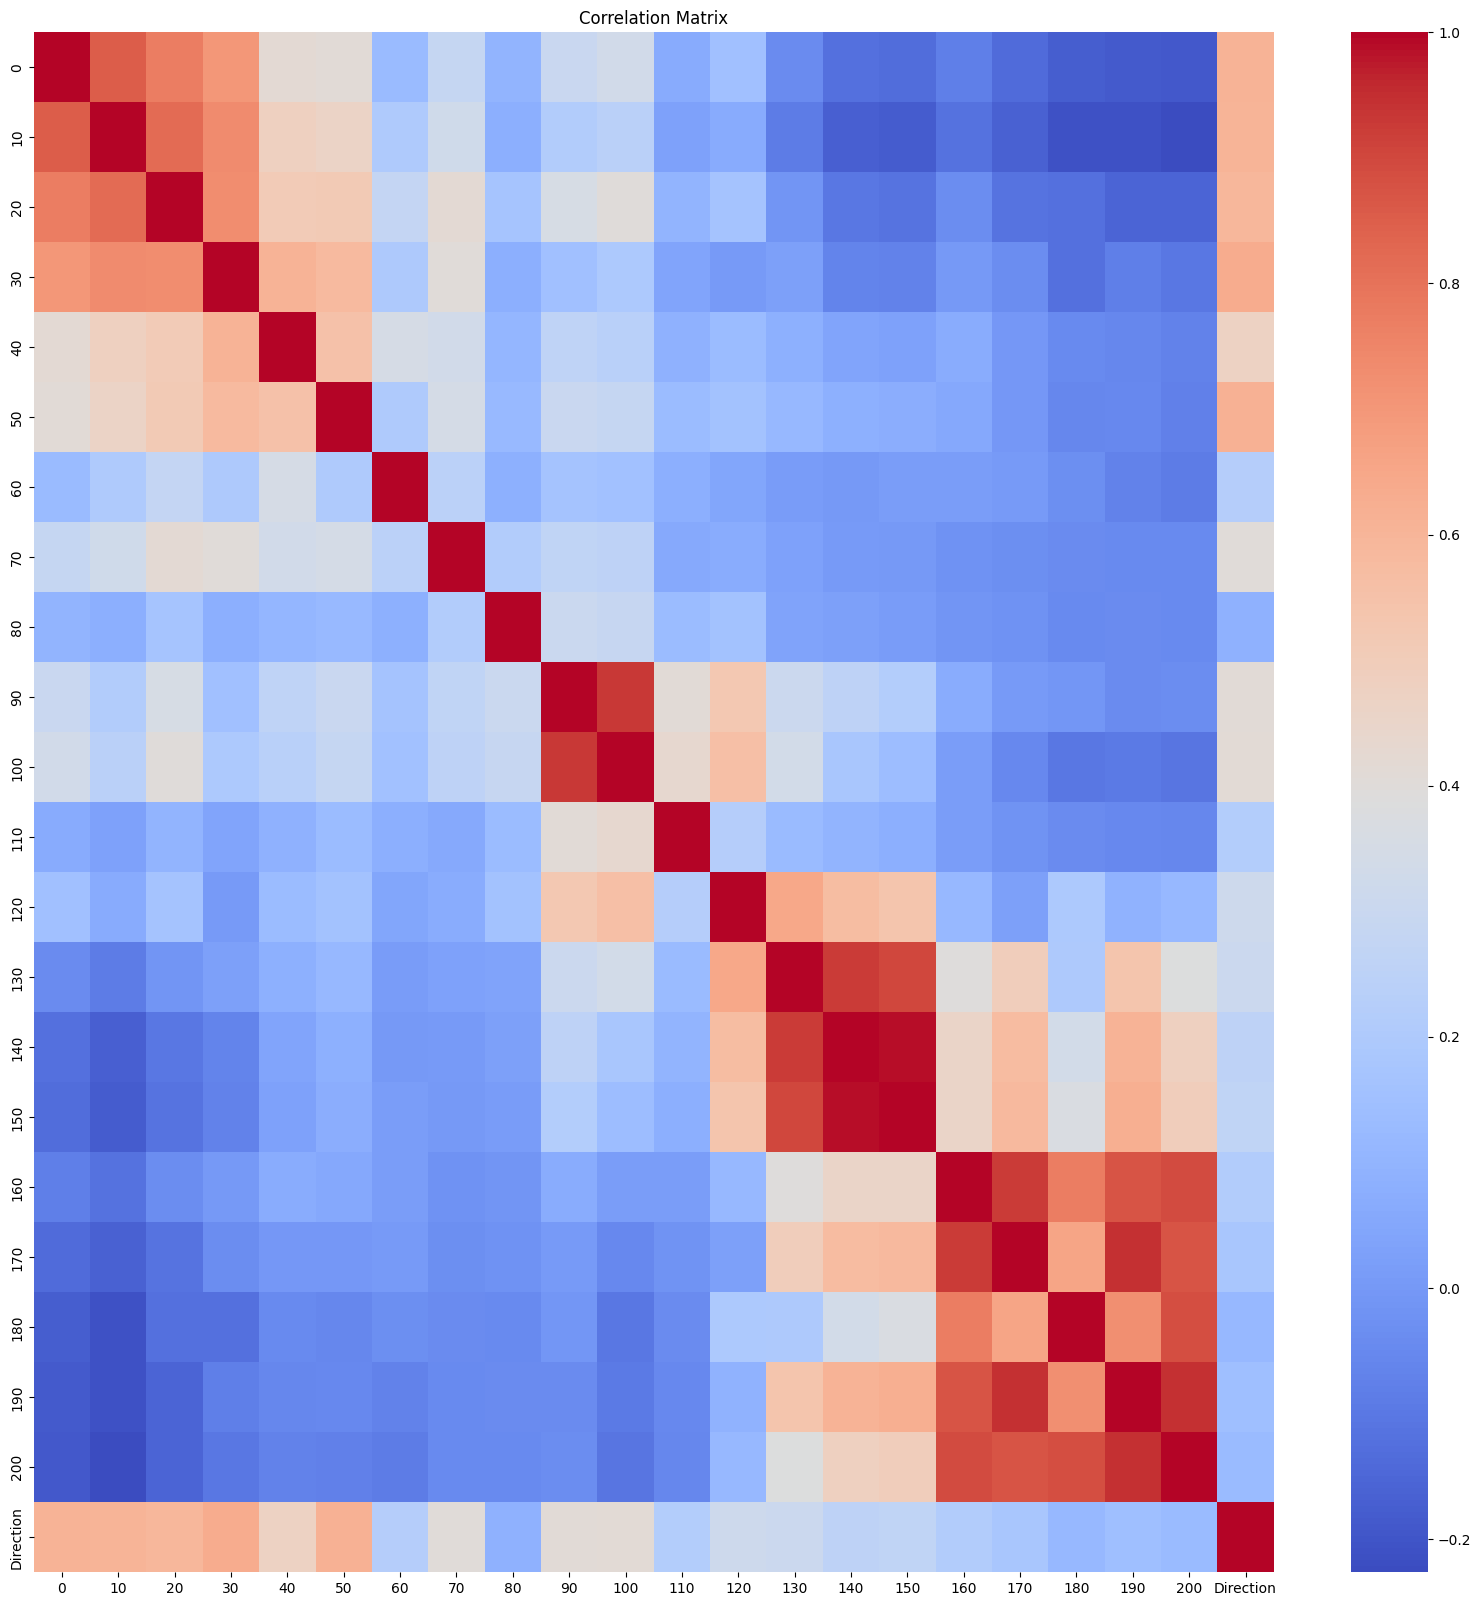

In [54]:
correlation_matrix = train.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

In [55]:
X = train.drop(columns=['Direction'])  # 特征
y = train['Direction']  # 目标变量

In [58]:
# 创建 SMOTE 实例
smote = SMOTE(random_state=42)

# 进行过采样
X_resampled, y_resampled = smote.fit_resample(X, y)

# 转换为 DataFrame（可选）
train = pd.DataFrame(X_resampled, columns=X.columns)
train['Direction'] = y_resampled

In [60]:
print(train['Direction'].value_counts())

Direction
0    35
1    35
Name: count, dtype: int64


In [62]:
train = train.astype(np.float32)

In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   0          70 non-null     float32
 1   10         70 non-null     float32
 2   20         70 non-null     float32
 3   30         70 non-null     float32
 4   40         70 non-null     float32
 5   50         70 non-null     float32
 6   60         70 non-null     float32
 7   70         70 non-null     float32
 8   80         70 non-null     float32
 9   90         70 non-null     float32
 10  100        70 non-null     float32
 11  110        70 non-null     float32
 12  120        70 non-null     float32
 13  130        70 non-null     float32
 14  140        70 non-null     float32
 15  150        70 non-null     float32
 16  160        70 non-null     float32
 17  170        70 non-null     float32
 18  180        70 non-null     float32
 19  190        70 non-null     float32
 20  200        7

In [66]:
# split the dataset
rest_X, test_X, rest_y, test_y = train_test_split(train.drop(columns='Direction').values, 
                                                  train[['Direction']].values, 
                                                  test_size=0.2)
train_X, valid_X, train_y, valid_y = train_test_split(rest_X, rest_y, test_size=0.2)

In [71]:
# Data standardization
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
valid_X = scaler.transform(valid_X)

In [73]:
# create dataloaders
def create_dl(train_X, train_y, valid_X, valid_y, test_X, test_y):
    tensor_train_X = Tensor(train_X)
    tensor_valid_X = Tensor(valid_X)
    tensor_test_X = Tensor(test_X)
    tensor_train_y = Tensor(train_y)
    tensor_valid_y = Tensor(valid_y)
    tensor_test_y = Tensor(test_y)

    train_ds = TensorDataset(tensor_train_X, tensor_train_y)
    valid_ds = TensorDataset(tensor_valid_X, tensor_valid_y)
    test_ds = TensorDataset(tensor_test_X, tensor_test_y)

    train_dl = DataLoader(train_ds, batch_size=32)
    valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds))
    test_dl = DataLoader(test_ds, batch_size=len(test_ds))
    return train_dl, valid_dl, test_dl

train_dl, valid_dl, test_dl = create_dl( train_X, train_y, valid_X, valid_y, test_X, test_y )

In [75]:
next(iter(train_dl))

[tensor([[-3.4559e-01, -4.6096e-01, -6.1571e-01, -4.9613e-01, -5.3748e-01,
          -8.1681e-01, -5.5862e-01, -1.5709e-01,  2.3697e-01,  2.3866e-01,
           1.4578e-01,  2.1617e-01,  3.6393e-02,  7.9456e-02,  1.3876e-01,
           1.5872e-01,  1.9316e-01,  1.9101e-01,  1.9638e-01,  2.5884e-01,
           2.5747e-01],
         [ 4.2168e-01,  9.6109e-01,  1.0037e+00,  1.1766e+00,  1.6986e+00,
           1.6963e+00,  2.0989e+00, -8.4486e-01, -2.0328e+00, -2.1616e+00,
          -1.8498e+00, -1.3974e+00, -1.3216e-01,  8.9277e-04,  1.7446e-01,
           5.5065e-01,  4.4687e-01,  2.9106e-01,  2.2313e-01, -5.3267e-01,
          -8.8265e-01],
         [ 9.2852e-02, -5.9874e-02, -1.9658e-01, -1.7840e-01,  3.3270e-01,
          -3.6306e-01,  2.2837e-01, -1.3990e-01,  2.3697e-01,  2.3866e-01,
           1.4578e-01,  2.1617e-01,  3.6393e-02,  7.9456e-02,  1.3876e-01,
           1.5872e-01,  1.9316e-01,  1.9101e-01,  1.9638e-01,  2.5884e-01,
           2.5747e-01],
         [ 5.2133e-01,  1.58

In [77]:
def two_layer_perceptron(in_size: int, hidden_size: int):
    return nn.Sequential(
        nn.Linear(in_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid()
    )

In [79]:
def objective(trial):
    lr = trial.suggest_float('lr', 1e-2, 1e-1, log=True)
    hidden = trial.suggest_int('hidden', 0, 100)
    
    model = two_layer_perceptron(21, hidden)    
    t = Trainer(model, 
                loss=nn.BCELoss(), 
                train_dl=train_dl, 
                valid_dl=valid_dl, 
                metrics=f1_score,
                silent=True,
                halt_notebook=False)     
    t.train(100, lr=(lr/10, lr), cycle=10) 
    loss, f1 = t.optimum()
    return f1

In [85]:
sampler = optuna.samplers.RandomSampler()
s = create_study(direction='maximize', sampler=sampler)
s.optimize(objective, n_trials=50)

[I 2024-11-11 13:04:30,326] A new study created in memory with name: no-name-85c9967a-1cb9-4003-acd8-6895f247427b
[I 2024-11-11 13:04:31,632] Trial 0 finished with value: 1.0 and parameters: {'lr': 0.012990502904304719, 'hidden': 41}. Best is trial 0 with value: 1.0.
[I 2024-11-11 13:04:32,665] Trial 1 finished with value: 0.888888888888889 and parameters: {'lr': 0.03516850171241484, 'hidden': 86}. Best is trial 0 with value: 1.0.
[I 2024-11-11 13:04:33,777] Trial 2 finished with value: 1.0 and parameters: {'lr': 0.09496321288259328, 'hidden': 8}. Best is trial 0 with value: 1.0.
[I 2024-11-11 13:04:34,835] Trial 3 finished with value: 0.888888888888889 and parameters: {'lr': 0.06404041805254912, 'hidden': 40}. Best is trial 0 with value: 1.0.
[I 2024-11-11 13:04:35,887] Trial 4 finished with value: 0.888888888888889 and parameters: {'lr': 0.057114894480120616, 'hidden': 96}. Best is trial 0 with value: 1.0.
[I 2024-11-11 13:04:36,991] Trial 5 finished with value: 1.0 and parameters: {

C:\Users\yil\AppData\Local\Temp\ipykernel_21352\1652978769.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(s, params=['lr', 'hidden']);
[W 2024-11-11 13:05:27,725] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


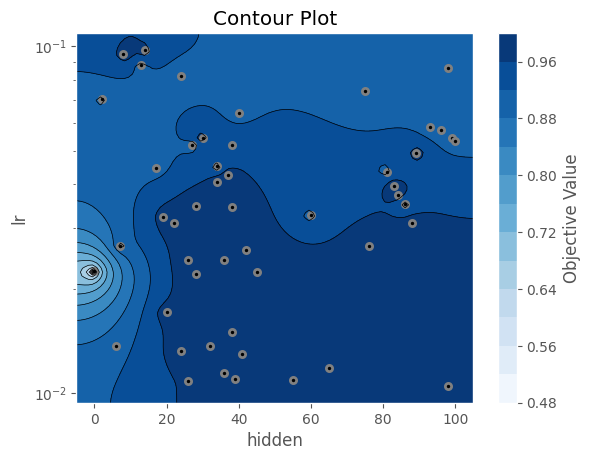

In [87]:
plot_contour(s, params=['lr', 'hidden']);